Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0633 - val_loss: 0.0490
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - val_loss: 8.5140e-04
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 4.4777e-04
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4641e-04 - val_loss: 6.7332e-04
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5479e-04 - val_loss: 3.7469e-04
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8347e-04 - val_loss: 2.7504e-04
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0810e-04 - val_loss: 3.0792e-04
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1797e-04 - val_loss: 2.0999e-04
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2290e-04 - val_loss: 2.4785e-04
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5404e-04 - val_loss: 1.3413e-04
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4518e-04 - val_loss: 1.1364e-04
E

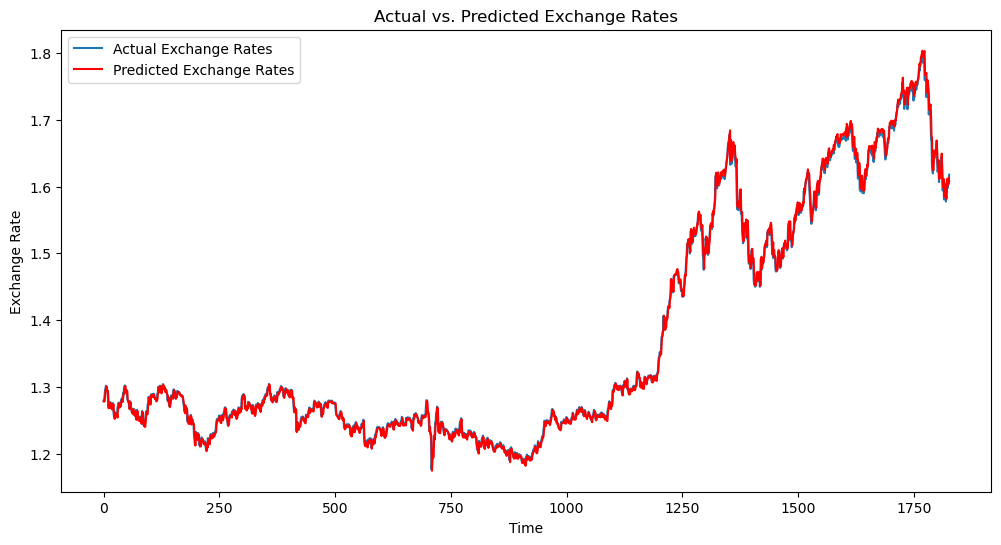

In [32]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# Redefine column names since the previous variables were lost
column_names = ['Date', 'chinese_yuan', 'euro', 'japanese_yen', 'uk_pound', 'us_dollar', 
                'algerian_dinar', 'australian_dollar', 'bahrain_dinar', 'botswana_pula', 
                'brazilian_real', 'brunei_dollar', 'canadian_dollar', 'chilean_peso', 
                'colombian_peso', 'czech_koruna', 'danish_krone', 'hungarian_forint', 
                'icelandic_krona', 'indian_rupee', 'indonesian_rupiah', 'iranian_rial', 
                'israeli_new_shekel', 'kazakhstani_tenge', 'korean_won', 'kuwaiti_dinar', 
                'libyan_dinar', 'malaysian_ringgit', 'mauritian_rupee', 'mexican_peso', 
                'nepalese_rupee', 'new_zealand_dollar', 'norwegian_krone', 'omani_rial', 
                'pakistani_rupee', 'peruvian_sol', 'philippine_peso', 'polish_zloty', 
                'qatari_riyal', 'russian_ruble', 'saudi_arabian_riyal', 'singapore_dollar', 
                'south_african_rand', 'sri_lankan_rupee', 'swedish_krona', 'swiss_franc', 
                'thai_baht', 'trinidadian_dollar', 'tunisian_dinar', 'uae_dirham', 
                'uruguayan_peso', 'bolivar_fuerte']

# Reload dataset with the specified column names
exchange_data = pd.read_csv('C:/Users/15016/Documents/Capstone Project/exchange rates.csv', 
                             names=column_names, 
                             header=0,  # Skip the first row if it has no valid headers
                             parse_dates=['Date'], 
                             index_col='Date')

# Handle missing data with forward fill and backward fill to ensure all values are filled
exchange_data.ffill(inplace=True)
exchange_data.bfill(inplace=True)

# Additional check to identify which columns still have NaN values
nan_columns = exchange_data.columns[exchange_data.isna().any()].tolist()
if len(nan_columns) > 0:
    print(f"Columns with remaining NaN values: {nan_columns}")
    # Optionally, fill remaining NaN values with the mean of each column
    exchange_data.fillna(exchange_data.mean(), inplace=True)

# Final check to ensure no NaN values are left
if exchange_data.isna().sum().sum() > 0:
    raise ValueError("Data contains NaN values even after applying fills.")

# Scaling the data - using 'australian_dollar' as the target
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(exchange_data[['australian_dollar']])

# Create sequences of 15 time steps
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Set initial time_step to 1 
time_step = 10  
X, y = create_sequences(scaled_data, time_step=time_step)


# Build the LSTM model using Input
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))  # Specify input shape here
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))

# Make predictions
predicted_exchange_rates = model.predict(X_test)

# Ensure no NaN in predictions
if np.isnan(predicted_exchange_rates).sum() > 0:
    raise ValueError("Predicted values contain NaN. Please check the model output.")

# Invert scaling to get actual values
predicted_exchange_rates = scaler.inverse_transform(predicted_exchange_rates)
actual_exchange_rates = scaler.inverse_transform(y_test.reshape(-1, 1))

# Ensure shapes are consistent for metric calculations
if predicted_exchange_rates.shape != actual_exchange_rates.shape:
    raise ValueError("Shape mismatch between actual and predicted values.")

# Calculate error metrics
mse = mean_squared_error(actual_exchange_rates, predicted_exchange_rates)
mae = mean_absolute_error(actual_exchange_rates, predicted_exchange_rates)
r_squared = r2_score(actual_exchange_rates, predicted_exchange_rates)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r_squared}")

# Plot actual vs. predicted exchange rates
plt.figure(figsize=(12, 6))
plt.plot(actual_exchange_rates, label='Actual Exchange Rates')
plt.plot(predicted_exchange_rates, label='Predicted Exchange Rates', color='red')
plt.title('Actual vs. Predicted Exchange Rates')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()
